<a href="https://colab.research.google.com/github/educanto/colorectal_histology_classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.14.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.2 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import math

# **Some functions**

In [4]:
def plot_top_losses(loss_values, x_test, y_test, probs, k=9, figsize=(10,10)):
    top_k = loss_values.argsort()[-k:][::-1]
    print('top losses indexes: ', top_k)
    print(labels)
    cols = math.ceil(math.sqrt(k))
    rows = math.ceil(k/cols)
    fig,axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14).set_position([.5, 1.05])
    i=0
    for index in top_k:
        image = x_test[index]
        actual = y_test[index]
        loss_value = loss_values[index]
        predicted = np.argmax(probs[index])
        prob = probs[index][predicted]
        title = f'{predicted}/{actual}/{loss_value:.2f}/{prob:.2f}'
        ax = axes.flat[i]
        i+=1
        image = np.squeeze(image)
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
    fig.tight_layout()

**Callback to save the best model**

In [5]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()
        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

# **Load dataset**

In [6]:
dataset, info = tfds.load('colorectal_histology', split='train', with_info=True)
# https://www.tensorflow.org/datasets/catalog/colorectal_histology

labels = {
    0: 'epitélio tumoral',
    1: 'estroma simples',
    2: 'estroma complexo',
    3: 'cong. de células imun.',
    4: 'resíduos e muco',
    5: 'glândulas mucosas',
    6: 'tecido adiposo',
    7: 'fundo'
}

info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteLSAF84/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_dir=PosixGPath('/tmp/tmpc9w8gp84tfds'),
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(150, 150, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, F

In [7]:
x = [example['image'].numpy() for example in dataset]
y = [example['label'].numpy() for example in dataset]

x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.3, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

x_train, x_val, x_test = np.array(x_train), np.array(x_val), np.array(x_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

# **Checking dataset**

In [8]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.min())
print(y_train.max())

np.unique(y, return_counts=True)

(3500, 150, 150, 3)
(750, 150, 150, 3)
(750, 150, 150, 3)
0
7


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([625, 625, 625, 625, 625, 625, 625, 625]))

# **Show some data**

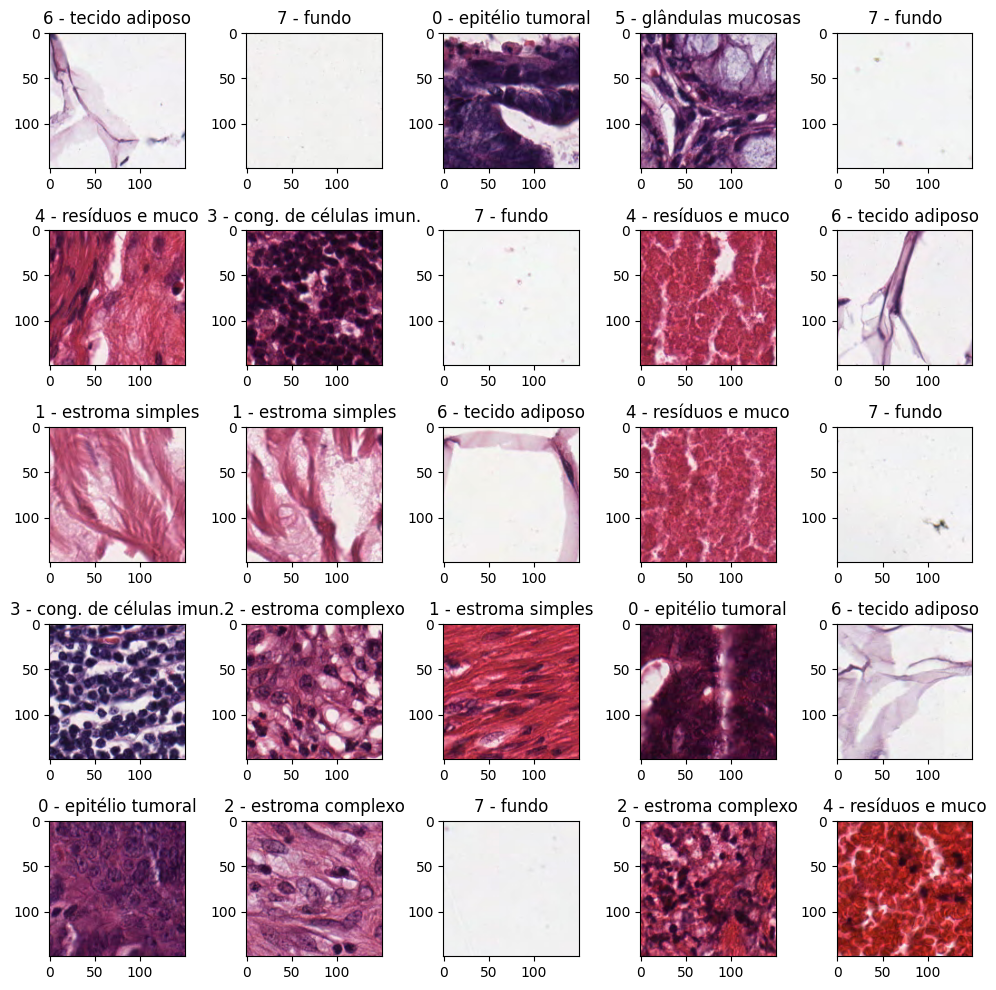

In [9]:
rows = 5
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
k = 0
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(x_train[k])
        axes[i, j].set_title(f"{y_train[k]} - {labels[y_train[k]]}")
        k += 1

plt.tight_layout()
plt.show()

# **Normalize images**

In [10]:
x_train_norm = x_train/float(255)
x_val_norm = x_val/float(255)
x_test_norm = x_test/float(255)

# **Create and compile model**

In [11]:
def create_model():
    # input_layer = tf.keras.layers.Input(shape=(150, 150, 3))

    # conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(input_layer)
    # maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    # conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(maxpool1)
    # maxpool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    # conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool2)
    # maxpool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    # flatten = tf.keras.layers.Flatten()(maxpool3)

    # dense1 = tf.keras.layers.Dense(32, activation='relu')(flatten)
    # dropout1 = tf.keras.layers.Dropout(0.2)(dense1)

    # output_layer = tf.keras.layers.Dense(len(labels), activation='softmax')(dropout1)

    # model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    for layer in base_model.layers:
        layer.trainable = False

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(base_model.output)
    dense_layer = tf.keras.layers.Dense(256, activation='relu', name='dense')(global_average_layer)
    dropout_layer = tf.keras.layers.Dropout(0.5, name='dropout')(dense_layer)
    output_layer = tf.keras.layers.Dense(len(labels), activation='softmax', name='output')(dropout_layer)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)
    return model

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

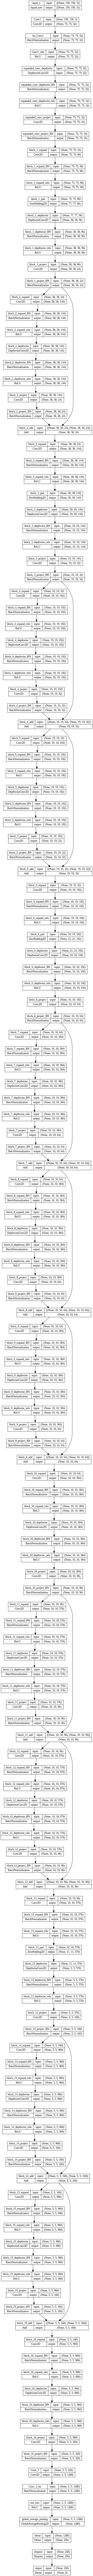

In [12]:
model = create_model()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-04)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

save_best_model = SaveBestModel()
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
            save_best_model]

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# **Train model**

In [13]:
history = model.fit(x_train_norm, y_train,
                    batch_size=64,
                    epochs=40,
                    validation_data=(x_val_norm, y_val),
                    callbacks=callbacks)

Epoch 1/40
55/55 [==============================] - 81s 1s/step - loss: 1.7226 - accuracy: 0.4069 - val_loss: 0.9412 - val_accuracy: 0.6880
Epoch 2/40
55/55 [==============================] - 65s 1s/step - loss: 0.9726 - accuracy: 0.6509 - val_loss: 0.7110 - val_accuracy: 0.7707
Epoch 3/40
55/55 [==============================] - 65s 1s/step - loss: 0.7696 - accuracy: 0.7283 - val_loss: 0.6213 - val_accuracy: 0.7893
Epoch 4/40
55/55 [==============================] - 66s 1s/step - loss: 0.6546 - accuracy: 0.7737 - val_loss: 0.5577 - val_accuracy: 0.8133
Epoch 5/40
55/55 [==============================] - 73s 1s/step - loss: 0.6073 - accuracy: 0.7857 - val_loss: 0.5299 - val_accuracy: 0.8320
Epoch 6/40
55/55 [==============================] - 66s 1s/step - loss: 0.5349 - accuracy: 0.8254 - val_loss: 0.5076 - val_accuracy: 0.8413
Epoch 7/40
55/55 [==============================] - 74s 1s/step - loss: 0.5129 - accuracy: 0.8297 - val_loss: 0.4750 - val_accuracy: 0.8453
Epoch 8/40
55/55 [==

**Get weigths from the best model (optional)**

In [14]:
print(save_best_model.best)
model.set_weights(save_best_model.best_weights)

0.354642778635025


# **Results**

# **Results**

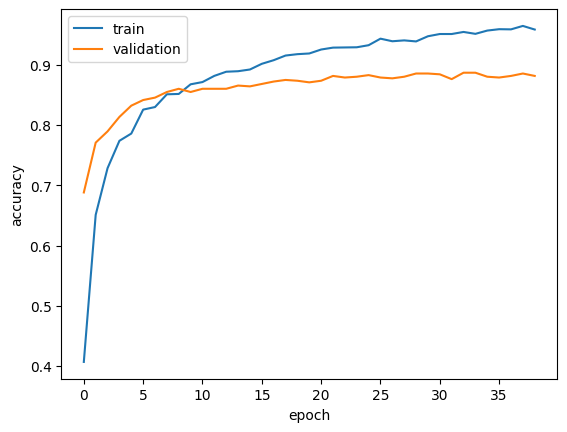

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

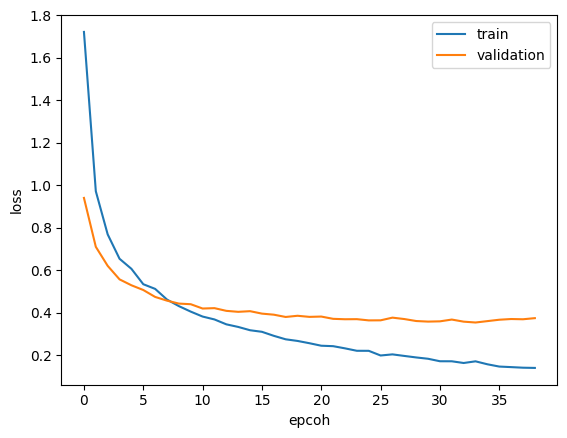

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epcoh')
plt.ylabel('loss')
plt.legend(['train', 'validation'])

# **Evaluating the model**

In [17]:
test_loss, acc_test = model.evaluate(x_test_norm, y_test)
print('test loss:', test_loss)
print('test accuracy:', acc_test)

24/24 [==============================] - 10s 413ms/step - loss: 0.3694 - accuracy: 0.8773
test loss: 0.3694148361682892
test accuracy: 0.8773333430290222


# **Plotting top losses**

In [18]:
probs = model.predict(x_test_norm)
loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
loss_values = loss(y_test, probs).numpy()

24/24 [==============================] - 11s 438ms/step


top losses indexes:  [625 151 672 341  22 361 385 381 719 623 296 284 639  20 155  88]
{0: 'epitélio tumoral', 1: 'estroma simples', 2: 'estroma complexo', 3: 'cong. de células imun.', 4: 'resíduos e muco', 5: 'glândulas mucosas', 6: 'tecido adiposo', 7: 'fundo'}


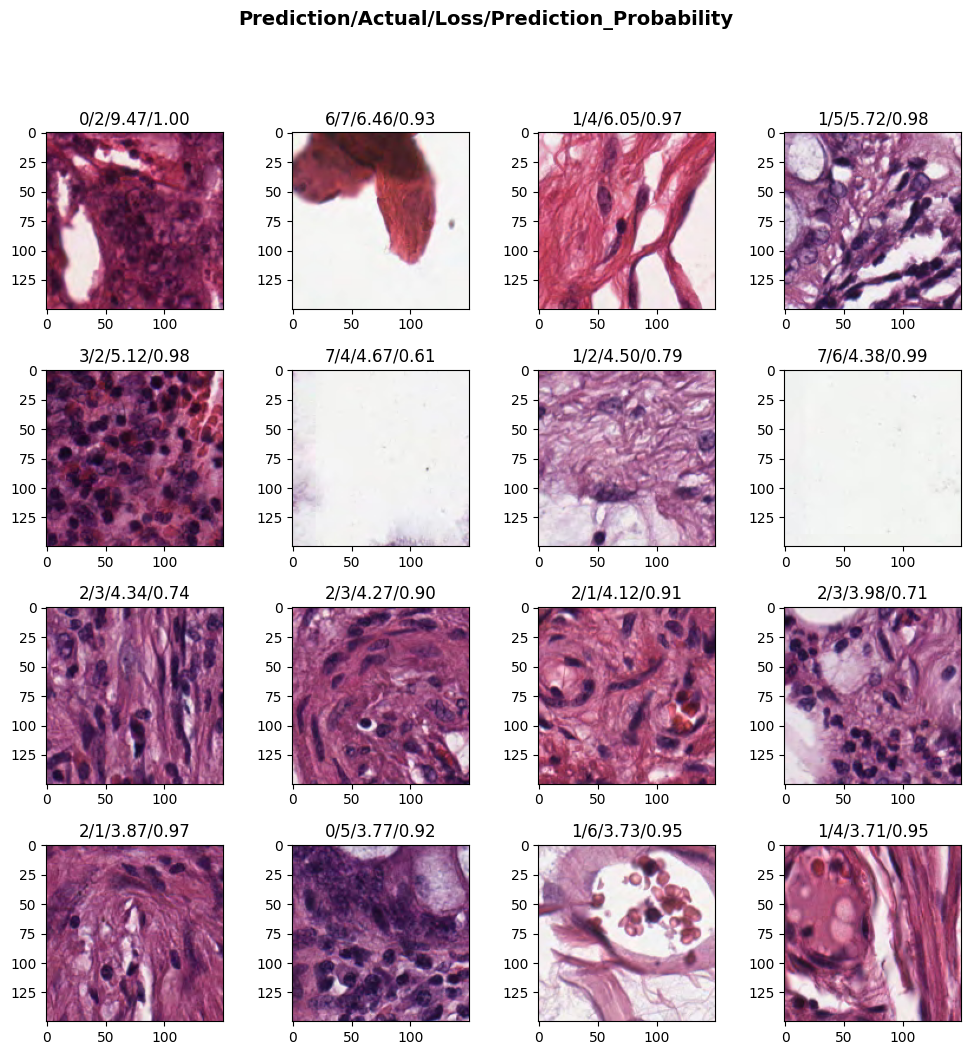

In [19]:
plot_top_losses(loss_values, x_test, y_test, probs, k=16)

# **Save model**

In [20]:
model.save('exported_model')

# **Testing loaded model**

In [21]:
loaded_model = tf.keras.models.load_model('exported_model')
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

In [22]:
test_pred = loaded_model.predict(x_test_norm)
print('test result:      ', np.argmax(test_pred, axis=1)[0:20])
print('test image number:', y_test[0:20])

24/24 [==============================] - 10s 363ms/step
test result:       [1 7 6 6 0 2 7 3 6 6 5 0 5 7 1 0 0 4 7 2]
test image number: [0 7 6 6 0 2 7 3 6 6 5 0 5 7 1 0 0 4 7 0]
